分析天气数据中影响共享单车需求量的因素，并将这些影响因素embedding

In [1]:
#导入包
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import math

In [2]:
#绘图设置
config = {
    'axes.unicode_minus': False,
}
%matplotlib inline
sns.set(context='notebook', style='ticks', rc=config)

In [3]:
#天气数据
weather_data = pd.read_hdf('raw_bike_data/nyc_bike_data_201907-201909.h5',key='weather_data_clean')
weather_data

,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
Time,,,,,,,,,
2019-07-01 01:00:00,21.666667,12.222222,55.0,NNW,19.312128,0.0,758.190,0.0,Fair
2019-07-01 02:00:00,21.111111,12.222222,57.0,NNW,16.093440,0.0,758.444,0.0,Fair
2019-07-01 03:00:00,20.555556,12.777778,61.0,NW,19.312128,0.0,758.698,0.0,Fair
2019-07-01 04:00:00,20.000000,13.333333,65.0,NW,20.921472,0.0,758.952,0.0,Fair
2019-07-01 05:00:00,20.000000,12.777778,63.0,NNW,14.484096,0.0,758.952,0.0,Fair
...,...,...,...,...,...,...,...,...,...
2019-09-30 20:00:00,19.444444,10.555556,57.0,ESE,12.874752,0.0,767.334,0.0,Cloudy
2019-09-30 21:00:00,18.888889,10.555556,59.0,SE,14.484096,0.0,767.334,0.0,Cloudy
2019-09-30 22:00:00,18.888889,11.111111,60.0,S,12.874752,0.0,767.334,0.0,Cloudy


In [4]:
#共享单车数据
#订单的开始时间作为需求产生的时间点
bike_data = pd.read_hdf('raw_bike_data/nyc_bike_data_201907-201909.h5',key='bike_data')
bike_data.drop(['etime', 'slon',
       'slat', 'elat',
       'elon'],inplace=True,axis=1)
bike_data['Demand'] =1
bike_data['stime'] = pd.to_datetime(bike_data['stime'])
bike_data = bike_data.set_index('stime')
bike_data = bike_data.resample(rule='H',label='right').sum()
bike_data

,Demand
stime,
2019-07-01 01:00:00,672
2019-07-01 02:00:00,359
2019-07-01 03:00:00,197
2019-07-01 04:00:00,115
2019-07-01 05:00:00,168
...,...
2019-09-30 20:00:00,5220
2019-09-30 21:00:00,3551
2019-09-30 22:00:00,2470


In [5]:
#将共享单车需求与天气数据合并
raw_data = weather_data.join(bike_data,how='inner')
raw_data.head()

,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,Demand
Time,,,,,,,,,,
2019-07-01 01:00:00,21.666667,12.222222,55.0,NNW,19.312128,0.0,758.190,0.0,Fair,672
2019-07-01 02:00:00,21.111111,12.222222,57.0,NNW,16.093440,0.0,758.444,0.0,Fair,359
2019-07-01 03:00:00,20.555556,12.777778,61.0,NW,19.312128,0.0,758.698,0.0,Fair,197
2019-07-01 04:00:00,20.000000,13.333333,65.0,NW,20.921472,0.0,758.952,0.0,Fair,115
2019-07-01 05:00:00,20.000000,12.777778,63.0,NNW,14.484096,0.0,758.952,0.0,Fair,168


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-07-01 01:00:00 to 2019-10-01 00:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2208 non-null   float64
 1   Dew Point    2208 non-null   float64
 2   Humidity     2208 non-null   float64
 3   Wind         2208 non-null   object 
 4   Wind Speed   2208 non-null   float64
 5   Wind Gust    2208 non-null   float64
 6   Pressure     2208 non-null   float64
 7   Precip.      2208 non-null   float64
 8   Condition    2208 non-null   object 
 9   Demand       2208 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 254.3+ KB


In [7]:
raw_data['Condition'].unique()

array(['Fair', 'Partly Cloudy', 'Mostly Cloudy', 'Cloudy', 'Haze',
       'Thunder', 'Light Rain', 'T-Storm', 'Rain',
       'Light Rain with Thunder', 'Heavy Rain', 'Heavy T-Storm',
       'Thunder in the Vicinity', 'Thunder / Windy',
       'Partly Cloudy / Windy', 'Fog', 'Heavy T-Storm / Windy',
       'Mostly Cloudy / Windy', 'Cloudy / Windy', 'Light Rain / Windy'],
      dtype=object)

In [8]:
#数据预处理
#1.更改天气条件字段

data_process = raw_data.copy(deep=True)
weather_mapping = {
    'Fair': '晴朗',
    'Partly Cloudy': '晴朗',
    'Partly Cloudy / Windy':'晴朗',
    'Mostly Cloudy': '多云',
    'Mostly Cloudy / Windy':'多云',
    'Cloudy / Windy':'多云',
    'Cloudy': '多云',
    'Haze': '雾霾',
    'Thunder': '雷暴',
    'T-Storm': '雷暴',
    'Thunder in the Vicinity': '雷暴',
    'Thunder / Windy': '雷暴',
    'Light Rain': '小雨',
    'Light Rain with Thunder': '小雨',
    'Light Rain / Windy': '小雨',
    'Rain': '大雨',
    'Heavy Rain': '大雨',
    'Heavy T-Storm': '大雨',
    'Heavy T-Storm / Windy': '大雨',
    'Fog': '雾'
}
data_process['Condition'] = data_process['Condition'].replace(weather_mapping)
data_process.head()

,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,Demand
Time,,,,,,,,,,
2019-07-01 01:00:00,21.666667,12.222222,55.0,NNW,19.312128,0.0,758.190,0.0,晴朗,672
2019-07-01 02:00:00,21.111111,12.222222,57.0,NNW,16.093440,0.0,758.444,0.0,晴朗,359
2019-07-01 03:00:00,20.555556,12.777778,61.0,NW,19.312128,0.0,758.698,0.0,晴朗,197
2019-07-01 04:00:00,20.000000,13.333333,65.0,NW,20.921472,0.0,758.952,0.0,晴朗,115
2019-07-01 05:00:00,20.000000,12.777778,63.0,NNW,14.484096,0.0,758.952,0.0,晴朗,168


In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#分类编码
data_test = data_process.copy(deep=True)
data_test['Wind'] = data_test['Wind'].astype('category').cat.codes
data_test['Condition'] = data_test['Condition'].astype('category').cat.codes

# 使用RFE进行特征选择
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5)
selector = selector.fit(data_test[[ 'Dew Point','Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Wind Gust', 'Condition', 'Precip.']], data_test['Demand'])
print('Selected features:', selector.get_support(indices=True))


Selected features: [0 1 3 4 6]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

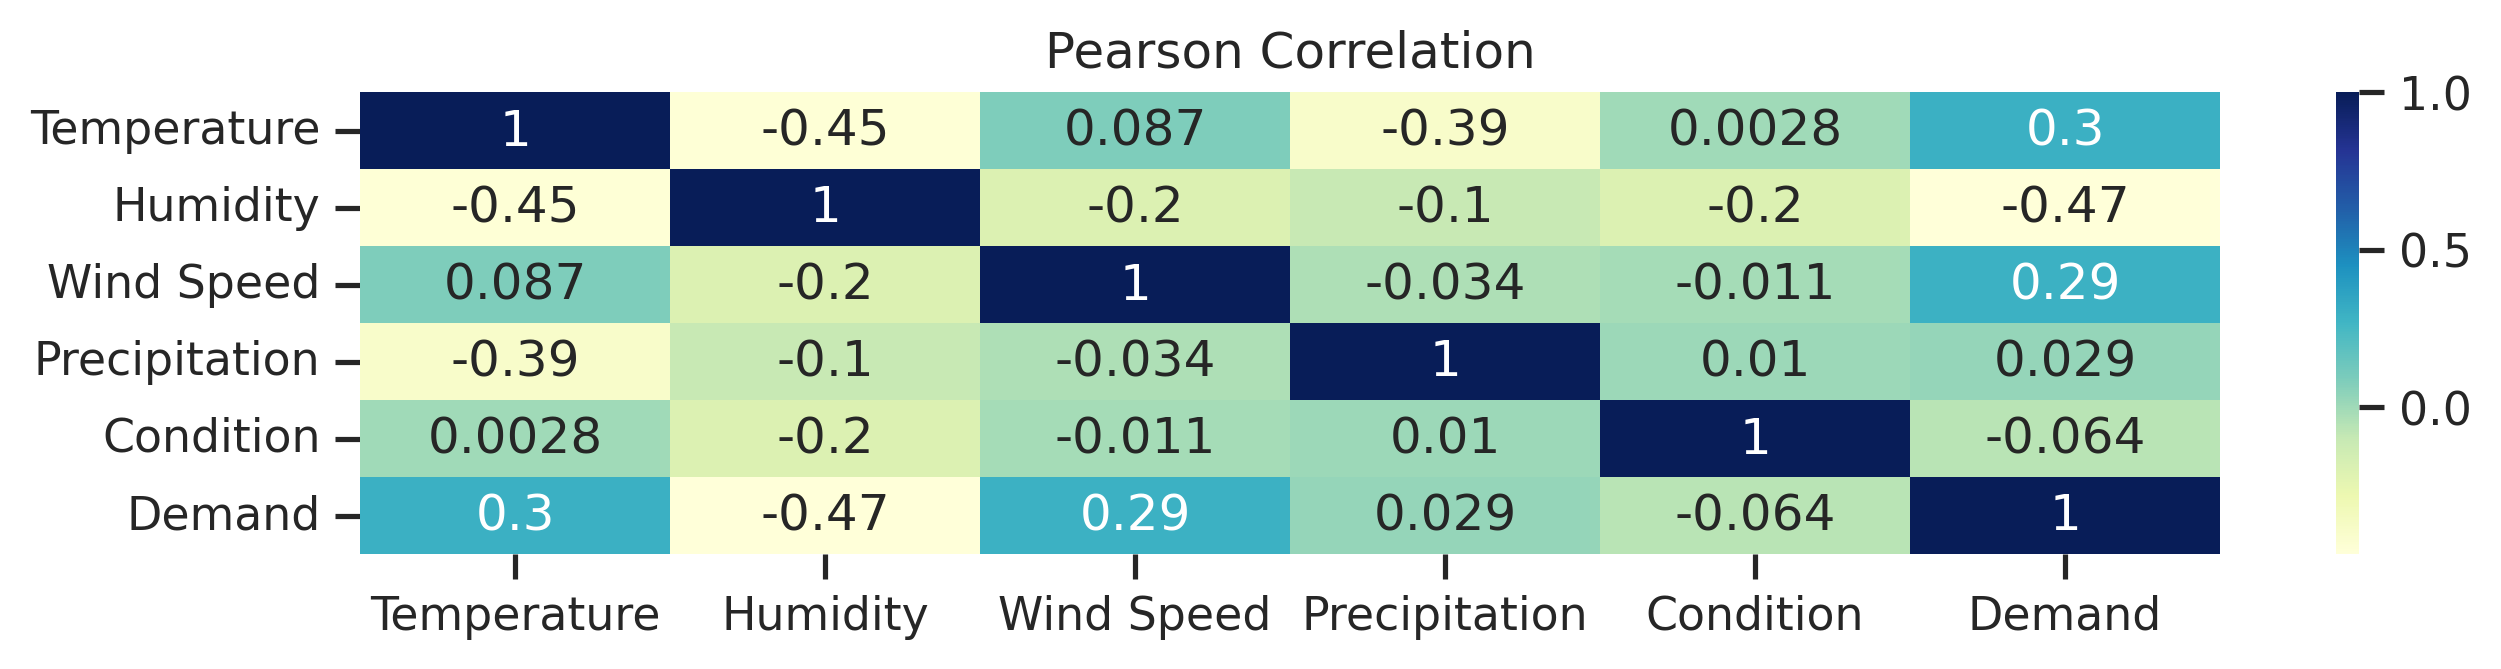

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
#局部全局设置
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.sans-serif'] = ['Arial']

#数据预处理
#2.删除多余字段
data_process.drop(['Dew Point','Wind Gust','Precip.','Wind'],axis=1,inplace=True)
data_process.columns = ['Temperature', 'Humidity', 'Wind Speed',
       'Precipitation', 'Condition', 'Demand']
data_test = data_process.copy(deep=True)
data_test['Condition'] = data_test['Condition'].astype('category').cat.codes
#相关系数
corr_pearson = data_test.corr(method='pearson')
corr_spearman = data_test.corr(method='spearman')

# 绘制某一列与其他列的相关性热力图
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 2),dpi=300)
sns.heatmap(corr_pearson, cmap="YlGnBu", annot=True, ax=ax1)
# sns.heatmap(corr_spearman[['Demand']], cmap="YlGnBu", annot=True, ax=ax2)

ax1.set_title("Pearson Correlation")
# ax2.set_title("Spearman Correlation")
# ax2.set_yticklabels('')
plt.show()


Text(0.5, 0, 'Precipitation')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

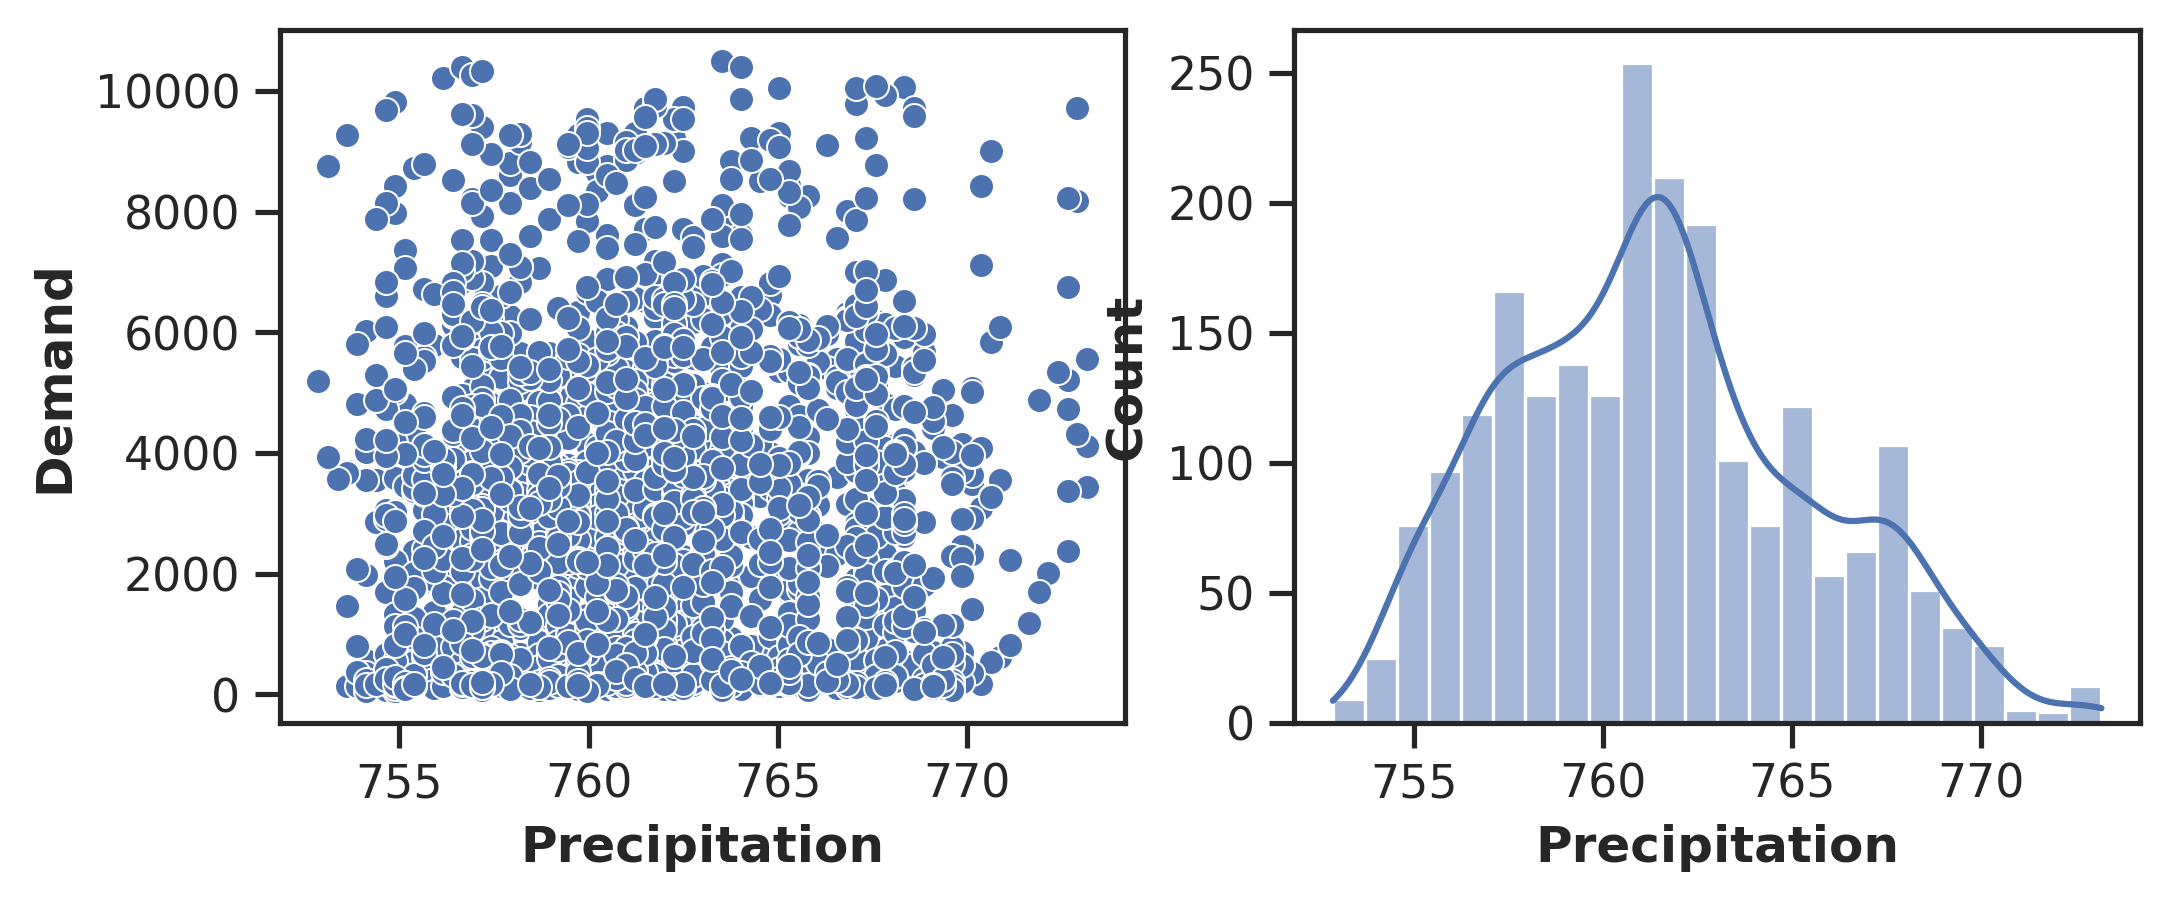

In [11]:
#绘制降雨量与需求量之间的关系

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 3),dpi=300)
# # 绘制降雨量与需求量的散点图
sns.scatterplot(x='Precipitation', y='Demand', data=data_process,ax=ax1)
# 绘制直方图
sns.histplot(data=data_process,x='Precipitation',kde=True,ax=ax2,fill=True)
# ax2.hist(data_process['Precipitation(mm)'], density=True, alpha=0.5,color='red')
# ax2.set_ylabel('Density')
# # 绘制正态分布曲线
# mu, std = norm.fit(data_process['Precipitation(mm)'])
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# ax2.plot(x, p, 'b', linewidth=2)

ax2.set_xlabel('Precipitation')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
/home/lihan/miniconda/envs/odfedgnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26228 (\N{CJK UNIFIED IDEOGRAPH-6674}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lihan/miniconda/envs/odfedgnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26391 (\N{CJK UNIFIED IDEOGRAPH-6717}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
/home/lihan/miniconda/envs/odfedgnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  fig.canvas.print_figure(by

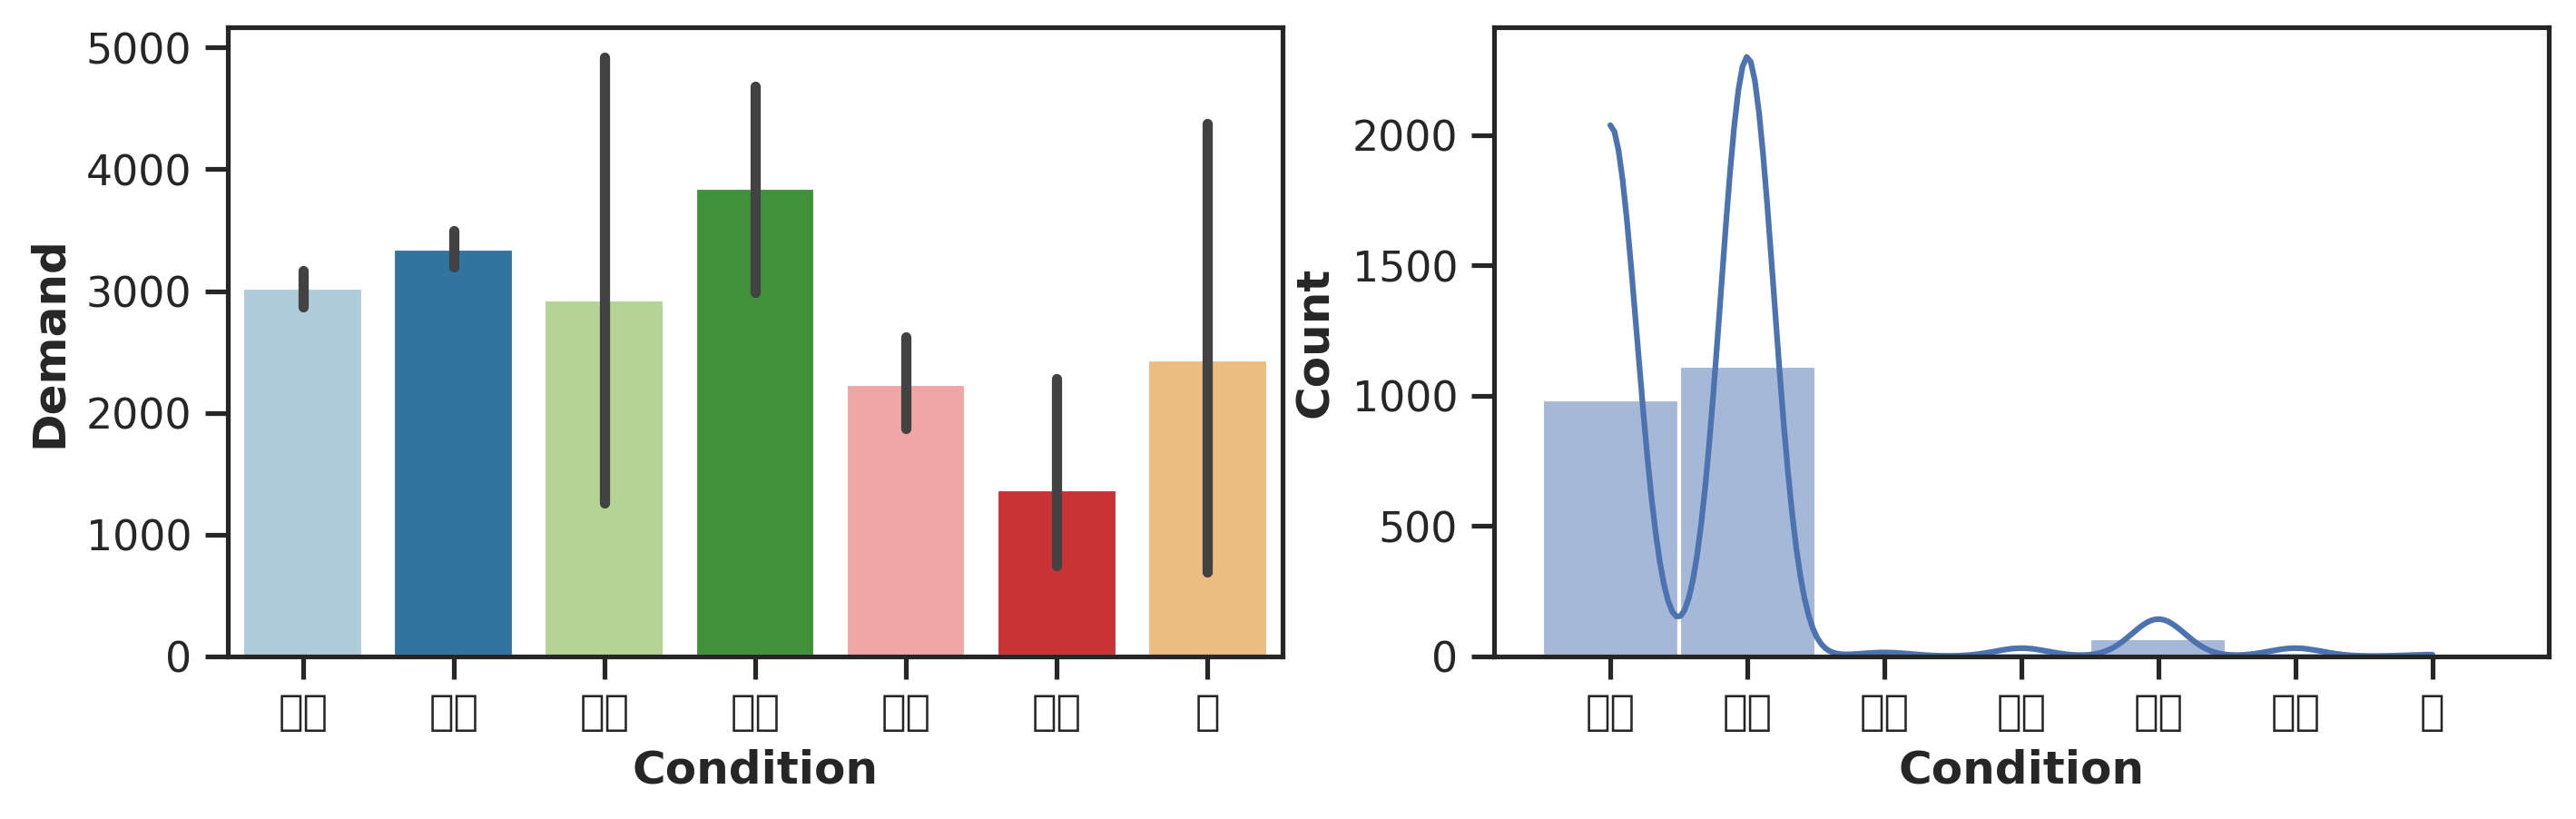

In [12]:
# 分析天气数据
import seaborn as sns
import matplotlib.pyplot as plt

# 选取需要分析的数据字段
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11, 3),dpi=300)


# 绘制天气条件与需求量的条形图
sns.barplot(x='Condition', y='Demand', data=data_process,ax=ax1,palette='Paired')

# ax2.hist(data_process['Condition'], density=True, alpha=0.5,color='blue')
sns.histplot(data=data_process,x='Condition',kde=True)
# 绘制正态分布曲线
# mu, std = norm.fit(data_process['Condition'].astype('category').cat.codes)
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# ax2.plot(x, p, 'r', linewidth=2)
# 展示图形
plt.show()


In [13]:
#构造时间特征
data_process = data_process.reset_index(names='Time')

# 定义节假日和周末日期
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2019-01-01', end='2019-12-31')
weekends = CustomBusinessDay(weekmask='Sat Sun')

holiday_hours = []
for holiday in holidays:
    holiday_hours.extend(pd.date_range(start=holiday, end=holiday + pd.Timedelta(hours=23), freq='H'))

# 构造日期索引
date_rng = pd.date_range(start='2019-01-01 01:00:00', end='2020-01-01 00:00:00', freq='H')

# 构造tem表
tem = pd.DataFrame(date_rng, columns=['Time'])
tem['is_weekday'] = np.where((tem['Time'].dt.weekday < 5) & ~(tem['Time'].isin(holiday_hours)), 1, 0)

data_process = pd.merge(data_process, tem[['Time', 'is_weekday']], on='Time', how='left')

# 构造新字段Period用于表示时间段
periods = ['凌晨', '早上', '上午', '中午', '下午', '傍晚', '晚上']
period_ranges = [(0, 4), (5, 7), (8, 11), (12, 12), (13, 17), (18, 19), (20, 23)]
data_process['Period'] = None

for i in range(len(periods)):
    start_hour = period_ranges[i][0]
    end_hour = period_ranges[i][1]
    data_process.loc[(data_process.Time.dt.hour >= start_hour) & (data_process.Time.dt.hour <= end_hour), 'Period'] = periods[i]
    
data_process.head()

,Time,Temperature,Humidity,Wind Speed,Precipitation,Condition,Demand,is_weekday,Period
0,2019-07-01 01:00:00,21.666667,55.0,19.312128,758.190,晴朗,672,1,凌晨
1,2019-07-01 02:00:00,21.111111,57.0,16.093440,758.444,晴朗,359,1,凌晨
2,2019-07-01 03:00:00,20.555556,61.0,19.312128,758.698,晴朗,197,1,凌晨
3,2019-07-01 04:00:00,20.000000,65.0,20.921472,758.952,晴朗,115,1,凌晨
4,2019-07-01 05:00:00,20.000000,63.0,14.484096,758.952,晴朗,168,1,早上


In [14]:
# 分析需求量与时间特征之间的关系(wsl上没有。。)
# from matplotlib import font_manager
# font_path = 'C:WINDOWS\FONTS\MSYHLTTC'
# prop = font_manager.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()
# plt.rcParams['font.sans-serif'] = prop.get_name()
# fig, ax1= plt.subplots(ncols=1, figsize=(6, 3),dpi=300)
# sns.barplot(data=data_process,x='Period',y='Demand',hue='is_weekday',ax=ax1,palette='Set2')


In [15]:
# #构造体表温度
# # 公式：
# # AT = -2.7 + 1.04*T + 2.0*e - 0.65*v

# # 定义计算函数
# def calculate_AT(row):
#     # 获取温度、相对湿度和风速值
#     T = row['Temperature(c)']
#     RH = row['Humidity(%)']
#     v = row['Wind Speed(km/h)']
#     # 计算水汽压
#     e = 6.105*math.exp(17.27*T/(T+237.3))*RH/100
#     # 计算体感温度
#     AT = -2.7 + 1.07*T + 0.2*e - 0.65*v
#     return AT

# # 应用计算函数并添加新列
# data_process['体感温度'] = data_process.apply(calculate_AT, axis=1)

# data_process

In [16]:
# from scipy.stats import shapiro
# import pandas as pd

# data_test = data_process.copy(deep=True)
# data_test['Condition'] = data_test['Condition'].astype('category').cat.codes
# # 选取“weather_condition”列中的数据，并将其转换为 NumPy 数组
# data1 = data_test['Precipitation(mm)'].values
# data2 = data_test['Condition'].values

# # 进行Shapiro-Wilk正态性检验
# stat, p1 = shapiro(data1)
# stat, p2 = shapiro(data2)

# # 输出检验结果
# if p1 > 0.05:
#     print('样本符合正态分布')
# else:
#     print('样本不符合正态分布')
# if p2 > 0.05:
#     print('样本符合正态分布')
# else:
#     print('样本不符合正态分布')


In [17]:
# Wilcoxon秩和检验是一种非参数检验方法，不需要假定数据服从特定的分布，但需要满足以下前提条件：

# 数据是随机抽取的样本；
# 两组数据是独立的，即一个样本的取值不会对另一个样本的取值产生影响；
# 数据可以通过大小比较，即数据具有大小关系，但不需要满足正态分布；
# 数据是连续的或者是有序的分类变量。
# Wilcoxon秩和检验常用于比较两组独立样本的中位数是否相等，或者比较同一组样本在两个时间点或两个条件下的中位数是否相等。


# Spearman等级相关检验的前提假设是：

# 样本数据是独立同分布的。
# 两个变量之间的关系是单调的，即随着一个变量的增加，另一个变量的值也会相应地增加或减少。
# 变量的排名是可以计算的，即每个变量的值都可以用一个具有唯一顺序的排名表示。
# 需要注意的是，Spearman等级相关检验是非参数检验方法，与Pearson相关性系数检验相比，它对数据的分布没有假设。但是，它仍然有一些前提假设，如上述所述。

# Pearson相关性系数检验有以下前提假设：

# 变量呈正态分布或近似正态分布；
# 变量是连续变量；
# 变量之间的关系是线性关系。
# 如果这些前提假设不满足，使用Pearson相关性系数可能会导致误判相关性强度和方向。如果数据不符合这些前提假设，可以考虑使用其他的相关性系数或非参数的假设检验方法。

In [18]:
# import pandas as pd
# from scipy.stats import pearsonr

# # 计算Pearson相关系数和p值
# corr, p_value = pearsonr(data_process['Precipitation(mm)'], data_process['Demand'])

# # 打印相关系数和p值
# print('Pearson correlation coefficient:', corr)
# print('p-value:', p_value)

# # 根据p值判断是否存在相关性
# if p_value < 0.05:
#     print('There is a significant correlation between weather condition and demand.')
# else:
#     print('There is no significant correlation between weather condition and demand.')

# # 计算Pearson相关系数和p值
# corr, p_value = pearsonr(data_process['Condition'], data_process['Demand'])

# # 打印相关系数和p值
# print('Pearson correlation coefficient:', corr)
# print('p-value:', p_value)

# # 根据p值判断是否存在相关性
# if p_value < 0.05:
#     print('There is a significant correlation between weather condition and demand.')
# else:
#     print('There is no significant correlation between weather condition and demand.')

In [19]:
from sklearn.decomposition import PCA

# 原始特征矩阵
X = data_process[['Temperature', 'Humidity']].values

# PCA降维
pca = PCA(n_components=1)
new_feature = pca.fit_transform(X)

# 将新特征与其他特征进行组合
data_process['Temp_Humidity'] = new_feature

#删除之前的特征
data_process.drop(['Temperature', 'Humidity'],axis=1,inplace=True)

/tmp/ipykernel_71924/1972510120.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_pearson = data_test.corr(method='pearson')
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findf

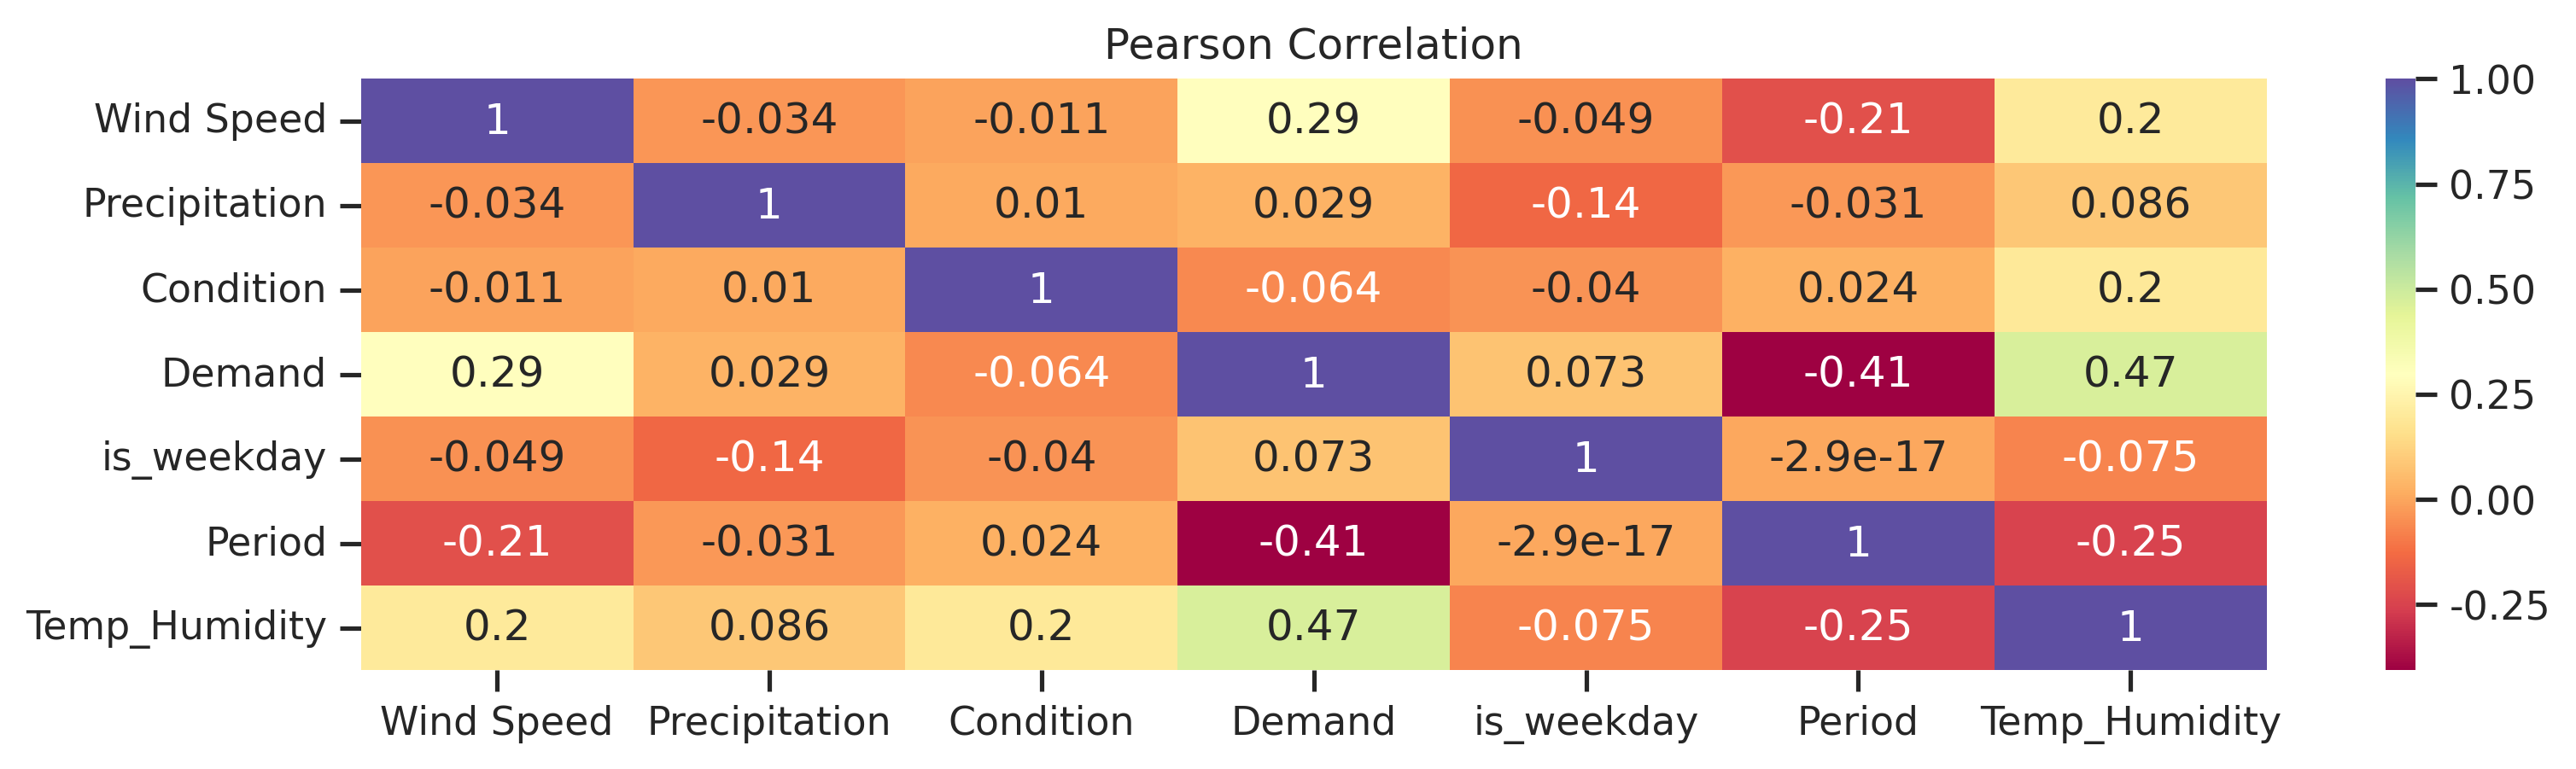

In [20]:
my_pattle = sns.color_palette("Spectral", as_cmap=True)
data_test = data_process.copy(deep=True)
data_test['Condition'] = data_test['Condition'].astype('category').cat.codes
data_test['Period'] = data_test['Period'].astype('category').cat.codes
#相关系数
corr_pearson = data_test.corr(method='pearson')

# 绘制相关性热力图
fig, ax1 = plt.subplots(ncols=1, figsize=(12, 3),dpi=300)
sns.heatmap(corr_pearson, cmap=my_pattle, annot=True, ax=ax1)
# sns.heatmap(corr_spearman[['Demand']], cmap="YlGnBu", annot=True, ax=ax2)
ax1.set_title("Pearson Correlation")
# ax2.set_title("Spearman Correlation")
plt.show()

In [21]:
data_process

,Time,Wind Speed,Precipitation,Condition,Demand,is_weekday,Period,Temp_Humidity
0,2019-07-01 01:00:00,19.312128,758.190,晴朗,672,1,凌晨,4.415981
1,2019-07-01 02:00:00,16.093440,758.444,晴朗,359,1,凌晨,2.361914
2,2019-07-01 03:00:00,19.312128,758.698,晴朗,197,1,凌晨,-1.676208
3,2019-07-01 04:00:00,20.921472,758.952,晴朗,115,1,凌晨,-5.714330
4,2019-07-01 05:00:00,14.484096,758.952,晴朗,168,1,早上,-3.730275
...,...,...,...,...,...,...,...,...
2203,2019-09-30 20:00:00,12.874752,767.334,多云,5220,1,晚上,2.151877
2204,2019-09-30 21:00:00,14.484096,767.334,多云,3551,1,晚上,0.097810
2205,2019-09-30 22:00:00,12.874752,767.334,多云,2470,1,晚上,-0.894218
2206,2019-09-30 23:00:00,16.093440,767.334,多云,1683,1,晚上,-0.894218


In [22]:
#保存到文件bike_od
data_process.set_index('Time',inplace=True)
data_process.drop(columns=['Demand'],inplace=True,axis=1)
data_process['Condition'] = data_process['Condition'].astype('category').cat.codes
data_process['Period'] = data_process['Period'].astype('category').cat.codes
# #追加保存
# with pd.HDFStore('./processed_data/bike_od.h5','a') as store:
#     store.put('weather_data', data_process)
with np.load('./processed_bike_data/bike_od_201907-201909.npz') as f:
    np.savez('./processed_bike_data/bike_od_201907-201909.npz', **f, weather_data=data_process.values)